# Self-Aware Classification with an “IDK” Label

In this notebook, we extend an MNIST digit classifier originally used to evaluate images generated by the UNet-DDPM classifier-free guidance model from the NVIDIA Generative AI with Diffusion Models course.

The classifier is augmented with an “IDK” (I Don’t Know) prediction option. When the model’s confidence falls below a chosen threshold, it outputs IDK instead of forcing a potentially unreliable digit prediction. This allows uncertain samples to be deferred for human review and provides insight into the model’s aleatoric uncertainty.

We first study how different confidence thresholds affect accuracy and coverage. The resulting predictions are then examined qualitatively using the FiftyOne app. Finally, the test set, together with predictions and metadata, is exported as a FiftyOne dataset for structured evaluation and further analysis.

In the next cell, we import the required modules, set random seeds for reproducibility, and define the configuration parameters and file paths used throughout the notebook.

Original code by [Antonio Rueda-Toicen](antonio@kineto.ai)
Parts of the implementation are reused and extended in this notebook.

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![](https://raw.githubusercontent.com/andandandand/practical-computer-vision/refs/heads/main/images/generated_mnist_digits_FO.png)



* U-Net: For the noise prediction network in the Denoising Diffusion Probabilisit Model (DDPM)
* Diffusion Process: Defines how noise is added (forward) and removed (reverse).
* MNIST Classifier: A standard convolutional neural network for classifying digits. It doesn't share gradients or information with the U-net, we use it just to evaluate the quality of predictions.
* Training Loops: One for the DDPM, one for the classifier.
* Sampling & Evaluation: Generating digits from the DDPM and classifying them.



# Benefits of U-Net's Downsampling-Upsampling Architecture in Diffusion Models

## Multi-scale Feature Processing
- U-Net captures hierarchical image features through progressive downsampling
- Lower resolutions encode global context and structure
- Higher resolutions preserve fine details and textures
- This multi-scale approach matches diffusion's noise characteristics at different timesteps

## Efficient Long-range Dependencies
- Downsampling increases effective receptive field without computational explosion
- Later timesteps (more noise) require global context to reconstruct structure
- Earlier timesteps (less noise) need local precision for detail refinement
- U-Net addresses both through its pyramidal architecture

## Skip Connections Preserve Information
- Skip connections between corresponding encoding/decoding layers maintain critical information
- These connections combat vanishing gradients in deep networks
- They create residual pathways that help preserve spatial details lost during downsampling
- Particularly valuable in diffusion models where preserving underlying image structure is essential

## Parameter Efficiency
- Downsampling reduces spatial dimensions, allowing deeper networks with manageable parameters
- Deeper networks capture more complex noise patterns across diffusion timesteps
- Upsampling gradually reconstructs spatial resolution while maintaining semantic understanding
- This efficiency enables handling the complex mapping from noisy to clean images

## Resolution-dependent Processing
- Different stages in diffusion process benefit from different resolution processing:
  - Early denoising (high noise): Benefits from low-resolution processing focused on structural elements
  - Late denoising (low noise): Requires high-resolution processing for detail refinement
- U-Net's architecture naturally aligns with this progression

## Consistent with Diffusion Physics
- Noise diffusion follows a coarse-to-fine pattern in physical systems
- U-Net's architecture mimics this natural process:
  - Downsampling path: Identifies global structures in highly noisy images
  - Upsampling path: Progressively refines details as noise levels decrease
- This alignment improves model convergence and generation quality

## Attention Integration
- Modern diffusion U-Nets incorporate self-attention at lower resolutions
- This combines convolutional inductive bias with transformer-like global reasoning
- Particularly valuable for coherent structure generation in highly degraded images

The U-Net architecture  balances global context and local detail processing, making it suited for the progressive denoising task of diffusion models across their full timestep spectrum.

## Install

In [ ]:
%%capture
!uv pip install fiftyone==1.5.2

In [ ]:
# Install dependencies
%%capture
%pip install --no-cache-dir -r requirements.txt

In [ ]:
# dependency from prev assignment
!pip -q install git+https://github.com/openai/CLIP.git

## Imports

In [2]:
import sys
from pathlib import Path
import shutil

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    #  !! Change the following path if the project is located elsewhere (repeat in config.py)
    %cd "/content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03"

PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

Mounted at /content/drive
/content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import shutil
import fiftyone as fo
from tqdm import tqdm
import torch.nn.functional as F

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

IMG_SIZE = 28 # MNIST image size
BATCH_SIZE_DDPM = 128
BATCH_SIZE_CLASSIFIER = 64
# Learning rates
LR_DDPM = 1e-3
LR_CLASSIFIER = 1e-3
EPOCHS_DDPM = 50 # Increase for better results (e.g., 100-200)
EPOCHS_CLASSIFIER = 10 # Usually converges faster
T = 300 # Number of diffusion timesteps (can be 200-1000)
SAVE_INTERVAL_DDPM = 10 # Save generated images every N epochs
OUTPUT_DIR = "ddpm_mnist_output"
CLASSIFIER_MODEL_PATH = os.path.join(OUTPUT_DIR, "mnist_classifier.pth")
DDPM_MODEL_PATH = os.path.join(OUTPUT_DIR, "ddpm_unet.pth")

os.makedirs(OUTPUT_DIR, exist_ok=True)


/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


Using device: cuda


In [4]:
# Set this to False in case that you don't want to use Google Drive to store models and generated images
DRIVE_AVAILABLE = True

## Define Model Paths

In [ ]:
# Base directory for models on Google Drive
DRIVE_MODEL_ROOT_DIR = "/content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03"
if DRIVE_AVAILABLE:
    os.makedirs(DRIVE_MODEL_ROOT_DIR, exist_ok=True)

# Local output directory (as before)
LOCAL_OUTPUT_DIR = "ddpm_mnist_output"
os.makedirs(LOCAL_OUTPUT_DIR, exist_ok=True)

# Model file names
CLASSIFIER_MODEL_FILENAME = "mnist_classifier.pth"
BEST_CLASSIFIER_MODEL_FILENAME = "best_mnist_classifier.pth"
DDPM_MODEL_FILENAME = "ddpm_unet.pth"
BEST_DDPM_MODEL_FILENAME = "best_ddpm_unet.pth"

# Local Paths
CLASSIFIER_MODEL_PATH_LOCAL = os.path.join(LOCAL_OUTPUT_DIR, CLASSIFIER_MODEL_FILENAME)
BEST_CLASSIFIER_MODEL_PATH_LOCAL = os.path.join(LOCAL_OUTPUT_DIR, BEST_CLASSIFIER_MODEL_FILENAME)
DDPM_MODEL_PATH_LOCAL = os.path.join(LOCAL_OUTPUT_DIR, DDPM_MODEL_FILENAME)
BEST_DDPM_MODEL_PATH_LOCAL = os.path.join(LOCAL_OUTPUT_DIR, BEST_DDPM_MODEL_FILENAME)

# Google Drive Paths (None if Drive not available)
CLASSIFIER_MODEL_PATH_DRIVE = os.path.join(DRIVE_MODEL_ROOT_DIR, LOCAL_OUTPUT_DIR, CLASSIFIER_MODEL_FILENAME) if DRIVE_AVAILABLE else None
BEST_CLASSIFIER_MODEL_PATH_DRIVE = os.path.join(DRIVE_MODEL_ROOT_DIR, LOCAL_OUTPUT_DIR, BEST_CLASSIFIER_MODEL_FILENAME) if DRIVE_AVAILABLE else None
DDPM_MODEL_PATH_DRIVE = os.path.join(DRIVE_MODEL_ROOT_DIR, LOCAL_OUTPUT_DIR, DDPM_MODEL_FILENAME) if DRIVE_AVAILABLE else None
BEST_DDPM_MODEL_PATH_DRIVE = os.path.join(DRIVE_MODEL_ROOT_DIR, LOCAL_OUTPUT_DIR, BEST_DDPM_MODEL_FILENAME) if DRIVE_AVAILABLE else None

print("--- Model Paths ---")
print(f"Local output directory: {LOCAL_OUTPUT_DIR}")
if DRIVE_AVAILABLE:
    print(f"Google Drive model directory: {DRIVE_MODEL_ROOT_DIR}")
else:
    print("Google Drive not available. Models will be local only.")

print(f"Local Classifier (Final): {CLASSIFIER_MODEL_PATH_LOCAL}")
print(f"Local Classifier (Best): {BEST_CLASSIFIER_MODEL_PATH_LOCAL}")
print(f"Local DDPM (Final): {DDPM_MODEL_PATH_LOCAL}")
print(f"Local DDPM (Best): {BEST_DDPM_MODEL_PATH_LOCAL}")

if DRIVE_AVAILABLE:
    print(f"Drive Classifier (Final): {CLASSIFIER_MODEL_PATH_DRIVE}")
    print(f"Drive Classifier (Best): {BEST_CLASSIFIER_MODEL_PATH_DRIVE}")
    print(f"Drive DDPM (Final): {DDPM_MODEL_PATH_DRIVE}")
    print(f"Drive DDPM (Best): {BEST_DDPM_MODEL_PATH_DRIVE}")

--- Model Paths ---
Local output directory: ddpm_mnist_output
Google Drive model directory: /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03
Local Classifier (Final): ddpm_mnist_output/mnist_classifier.pth
Local Classifier (Best): ddpm_mnist_output/best_mnist_classifier.pth
Local DDPM (Final): ddpm_mnist_output/ddpm_unet.pth
Local DDPM (Best): ddpm_mnist_output/best_ddpm_unet.pth
Drive Classifier (Final): /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/mnist_classifier.pth
Drive Classifier (Best): /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/best_mnist_classifier.pth
Drive DDPM (Final): /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/ddpm_unet.pth
Drive DDPM (Best): /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/best_ddpm_unet.pth


In [ ]:
# Cell 3: Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

IMG_SIZE = 28 # MNIST image size
BATCH_SIZE_DDPM = 128
BATCH_SIZE_CLASSIFIER = 64
# Learning rates
LR_DDPM = 1e-3
LR_CLASSIFIER = 1e-3

# SET THESE CAREFULLY:
# 0 means only load, >0 means train (or continue training if model loaded)
EPOCHS_DDPM = 0       # e.g., 50 for training, 0 for loading only
EPOCHS_CLASSIFIER = 0 # e.g., 10 for training, 0 for loading only

T = 300 # Number of diffusion timesteps (can be 200-1000)
SAVE_INTERVAL_DDPM = 10 # Save generated images every N epochs during DDPM training
# LOCAL_OUTPUT_DIR is used for non-model artifacts like sample images

Using device: cuda


In [ ]:
from utils import UNet_utils, ddpm_utils, other_utils, config, metrics

# Why We Use Positional Embeddings for Timesteps

Sinusoidal positional embeddings for timesteps `t` in Denoising Diffusion Probabilistic Models serve several critical functions:

## Purpose
- The U-Net predicts noise `ε` added to image `x_0` to produce `x_t`
- Noise characteristics depend on timestep `t` - early timesteps have minimal noise while late timesteps contain mostly noise
- The U-Net requires timestep information to predict the appropriate noise to remove

## Problems with Raw Integer Timesteps
- **Scale Issues:** Raw integers (0-1000) have disparate magnitudes that complicate neural network learning
- **Interpretation Gaps:** Networks may treat each integer as distinct, missing the relationship between adjacent timesteps
- **Limited Range:** Raw integers provide no framework for understanding timesteps outside training range
- **Insufficient Information:** A single scalar value lacks expressiveness for timestep representation

## Benefits of Sinusoidal Positional Embeddings
- **Unique Vectors:** Each timestep receives a distinct vector representation
- **Fixed Calculation:** Embeddings derive from sine/cosine functions rather than learning, providing consistency
- **Continuity:** Smooth functions create proximity between adjacent timesteps in embedding space, enabling interpolation
- **Structured Relationships:** For offset `k`, embedding of `t+k` can be expressed as linear function of embedding `t`
- **Frequency Spectrum:** Multiple frequencies capture both coarse and fine-grained timestep relationships:
  ```
  PE(t, 2i)   = sin(t / 10000^(2i / d_model))
  PE(t, 2i+1) = cos(t / 10000^(2i / d_model))
  ```
  - Low frequencies (large wavelengths) capture broad noise patterns
  - High frequencies (small wavelengths) differentiate between adjacent timesteps
- **Value Constraints:** Sine/cosine outputs bound between -1 and 1, stabilizing network training
- **Dimensional Richness:** Vector representation (256-512 dimensions) provides depth beyond scalar values

## Implementation in U-Net Architecture
- Integer timestep `t` converts to sinusoidal positional embedding vector
- This vector passes through a multi-layer perceptron for transformation
- The resulting embedding integrates with U-Net feature maps via addition or concatenation, conditioning the network on the noise level

In [7]:
#  Helper: Sinusoidal Positional Embeddings for Timesteps
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

## U-net Architecture

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            # For upsampling, conv1 takes concatenated input (skip + previous upsample)
            # The input channels to conv1 will be in_ch (from skip) + in_ch_prev_upsample
            # Here, in_ch is specified as the total input channels after concatenation.
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1) # Adjusted for explicit concat in UNet forward
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else: # Downsampling
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2] # Expand to match spatial dims
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class UNet(nn.Module):
    def __init__(self, img_channels=1, time_emb_dim=256):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection: (B, C, H, W) -> (B, 64, H, W)
        self.initial_conv = nn.Conv2d(img_channels, 64, 3, padding=1)

        # Downsampling path for 28x28 image
        # (B, 64, 28, 28) -> (B, 128, 14, 14)
        self.down1 = Block(64, 128, time_emb_dim)
        # (B, 128, 14, 14) -> (B, 256, 7, 7)
        self.down2 = Block(128, 256, time_emb_dim)

        # Bottleneck
        self.bot_conv1 = nn.Conv2d(256, 512, 3, padding=1) # Stays at 7x7
        self.bot_relu = nn.ReLU()
        self.bot_time_mlp = nn.Linear(time_emb_dim, 512) # Time embedding for bottleneck
        self.bot_conv2 = nn.Conv2d(512, 256, 3, padding=1) # Back to 256 channels, 7x7

        # Upsampling path
        # Skip from down2 (256 ch) + bottleneck output (256 ch) = 512 ch input
        # (B, 512, 7, 7) -> (B, 128, 14, 14)
        self.up1 = Block(256 + 256, 128, time_emb_dim, up=True)
        # Skip from down1 (128 ch) + up1 output (128 ch) = 256 ch input
        # (B, 256, 14, 14) -> (B, 64, 28, 28)
        self.up2 = Block(128 + 128, 64, time_emb_dim, up=True)

        # Final output layer
        # Input from up2 (64 ch) + initial_conv output for skip (64 ch) = 128 ch input
        # (B, 128, 28, 28) -> (B, img_channels, 28, 28)
        # A common U-Net pattern is to have a final conv that takes the last upsample layer's output
        # and potentially a skip from the very first layer.
        # Let's adjust self.output to take the output of up2 and the initial projection.
        self.output_conv = nn.Conv2d(64 + 64, img_channels, kernel_size=1)
        # Simpler: just use the output of up2 if that's the intended design
        # self.output_conv = nn.Conv2d(64, img_channels, kernel_size=1) # If no final skip

    def forward(self, x, timestep):
        t_emb = self.time_mlp(timestep)

        x0 = self.initial_conv(x) # (B, 64, 28, 28) - This is the first skip connection source

        # Downsample
        d1 = self.down1(x0, t_emb) # (B, 128, 14, 14)
        d2 = self.down2(d1, t_emb) # (B, 256, 7, 7)

        # Bottleneck
        b = self.bot_conv1(d2)    # (B, 512, 7, 7)
        time_emb_bot = self.bot_relu(self.bot_time_mlp(t_emb))
        time_emb_bot = time_emb_bot[(...,) + (None,) * 2]
        b = b + time_emb_bot
        b = self.bot_conv2(self.bot_relu(b)) # (B, 256, 7, 7)

        # Upsample with skip connections
        # up1 input: concat(b, d2) -> (B, 256+256=512, 7, 7)
        u1 = self.up1(torch.cat((b, d2), dim=1), t_emb)    # (B, 128, 14, 14)
        # up2 input: concat(u1, d1) -> (B, 128+128=256, 14, 14)
        u2 = self.up2(torch.cat((u1, d1), dim=1), t_emb)    # (B, 64, 28, 28)

        # Final output
        # Option 1: Concatenate with initial projection x0
        out = self.output_conv(torch.cat((u2, x0), dim=1)) # (B, C, 28, 28)
        # Option 2: If output_conv takes 64 channels (no final skip with x0)
        # out = self.output_conv(u2)
        return out

## Diffusion Process

In [9]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

class Diffusion:
    def __init__(self, timesteps=T, img_size=IMG_SIZE, device=DEVICE):
        self.timesteps = timesteps
        self.img_size = img_size
        self.device = device

        self.betas = linear_beta_schedule(timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        # Ensure F.pad is torch.nn.functional.pad
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alphas_cumprod_t = get_index_from_list(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    @torch.no_grad()
    def p_sample(self, model, x, t, t_index):
        betas_t = get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = get_index_from_list(self.sqrt_recip_alphas, t, x.shape)
        model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = get_index_from_list(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def sample(self, model, image_size, batch_size=16, channels=1):
        shape = (batch_size, channels, image_size, image_size)
        img = torch.randn(shape, device=self.device)
        imgs = []
        for i in tqdm(reversed(range(0, self.timesteps)), desc='Sampling loop', total=self.timesteps):
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)
            img = self.p_sample(model, img, t, i)
            if i % (self.timesteps // 10) == 0 or i < 10 :
                 imgs.append(img.cpu())
        imgs.append(img.cpu())
        return imgs

    def p_losses(self, denoise_model, x_start, t, noise=None, loss_type="l1"):
        if noise is None:
            noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        predicted_noise = denoise_model(x_noisy, t)
        if loss_type == 'l1':
            loss = F.l1_loss(noise, predicted_noise)
        elif loss_type == 'l2':
            loss = F.mse_loss(noise, predicted_noise)
        elif loss_type == "huber":
            loss = F.smooth_l1_loss(noise, predicted_noise)
        else:
            raise NotImplementedError()
        return loss

## MNIST Classifier

In [10]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

## Data Loading

In [11]:

transform_ddpm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_classifier = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# For DDPM training
train_dataset_ddpm = datasets.MNIST('.', train=True, download=True, transform=transform_ddpm)
train_loader_ddpm = DataLoader(train_dataset_ddpm, batch_size=BATCH_SIZE_DDPM, shuffle=True, drop_last=True)

# For Classifier training and evaluation
train_dataset_classifier = datasets.MNIST('.', train=True, download=True, transform=transform_classifier)
test_dataset_classifier = datasets.MNIST('.', train=False, download=True, transform=transform_classifier)
train_loader_classifier = DataLoader(train_dataset_classifier, batch_size=BATCH_SIZE_CLASSIFIER, shuffle=True)
test_loader_classifier = DataLoader(test_dataset_classifier, batch_size=BATCH_SIZE_CLASSIFIER, shuffle=False)

print("Datasets and DataLoaders ready.")

Datasets and DataLoaders ready.


## Visualizing the Forward Diffusion Process

This section visualizes the **forward diffusion process**, which is the foundation of Denoising Diffusion Probabilistic Models (DDPMs). The forward process describes how a clean, original image ($x_0$) is gradually corrupted by adding small amounts of [Gaussian noise](https://en.wikipedia.org/wiki/Gaussian_noise) over a series of discrete timesteps ($t$).

**What we are visualizing:**

We start with a single, clean sample image from the MNIST dataset ($x_0$). Then, for a sequence of increasing timesteps $t$ (from $t=0$ up to $t=T-1$, where $T$ is the total number of diffusion steps defined in our model), we apply the forward diffusion equation:

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$$

where:
*   $x_t$ is the noisy image at timestep $t$.
*   $x_0$ is the original clean image.
*   $\bar{\alpha}_t$ (alpha-bar-t) is a pre-computed noise schedule parameter that decreases as $t$ increases. This means more noise is effectively added at later timesteps.
*   $\epsilon$ is a sample from a standard Gaussian (normal) distribution.

**The Plot:**

The plot will display a row of images:
*   Each image in the row represents the state of the original $x_0$ after noise has been added up to the indicated timestep $t$.
*   The leftmost images (small $t$) will show the original image with very little noise.
*   As we move to the right (increasing $t$), the images will become progressively noisier.
*   The rightmost image (large $t$, close to $T-1$) will be almost entirely noise, with little to no discernible structure from the original image.

**Why is this important?**

Understanding the forward process is important because:
1.  It defines how the training data for the U-Net (the noise prediction model) is generated. The U-Net is trained to predict the noise $\epsilon$ that was added to $x_0$ to get $x_t$, given $x_t$ and $t$.
2.  The reverse process (which the U-Net learns to approximate) aims to undo this noise addition, step-by-step, starting from pure noise ($x_T$) and gradually denoising it back to a clean image ($x_0$). This reverse process is how new images are generated.

This visualization helps build intuition about the nature of the noisy inputs the U-Net will encounter during training and the progressive nature of the denoising task it must learn.

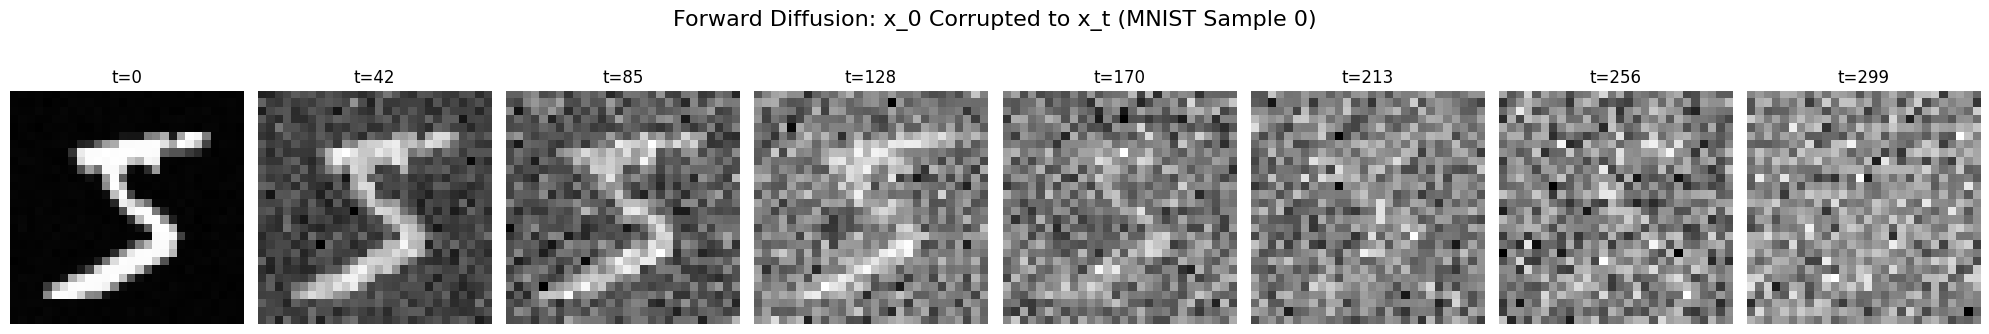

In [12]:

if 'train_dataset_ddpm' not in locals() or 'Diffusion' not in locals():
    print("Please ensure 'Data Loading' (Cell 8) and 'Diffusion Process' (Cell 6) have been run.")
else:
    # Create a diffusion instance specifically for this visualization
    # Note: 'T' from config is the total number of diffusion timesteps.
    # Timestep indices in the code usually go from 0 to T-1.
    diffusion_visualizer = Diffusion(timesteps=T, img_size=IMG_SIZE, device=DEVICE)

    # Get a sample image from the DDPM training dataset
    # The transform_ddpm has already scaled images to [-1, 1]
    sample_idx = 0 # You can change this index to see different digits
    x0_tensor, _ = train_dataset_ddpm[sample_idx]
    x0_tensor = x0_tensor.to(DEVICE) # Shape: (C, H, W)

    # --- Timesteps to visualize ---
    # We want to show how the image gets corrupted over time.
    # The `q_sample` function with t=0 (index) applies the first scheduled noise amount.
    num_images_to_plot = 8 # Total images to display in the row

    if T >= num_images_to_plot:
        # Select evenly spaced timesteps from 0 to T-1
        plot_t_indices = torch.linspace(0, T - 1, num_images_to_plot, dtype=torch.long).tolist()
    else:
        # If T is small, show all available steps up to num_images_to_plot
        plot_t_indices = torch.arange(0, T, dtype=torch.long).tolist()
        # Pad with the last step if num_images_to_plot is larger than T
        while len(plot_t_indices) < num_images_to_plot:
            plot_t_indices.append(T - 1 if T > 0 else 0)


    # --- Plotting ---
    fig, axes = plt.subplots(1, num_images_to_plot, figsize=(2.5 * num_images_to_plot, 3.5))
    fig.suptitle(f"Forward Diffusion: x_0 Corrupted to x_t (MNIST Sample {sample_idx})", fontsize=16)

    for i, t_idx_val in enumerate(plot_t_indices):
        ax = axes[i]

        # Prepare input for q_sample: batch of x0 and batch of timesteps
        x_start_batch = x0_tensor.unsqueeze(0)  # Shape: (1, C, H, W)
        t_batch = torch.tensor([t_idx_val], device=DEVICE, dtype=torch.long) # Shape: (1)

        # Apply forward diffusion q(x_t | x_0)
        # xt will be on DEVICE, shape (1, C, H, W)
        xt = diffusion_visualizer.q_sample(x_start_batch, t_batch)

        # Denormalize from [-1, 1] to [0, 1] for plotting
        # Squeeze batch dim, move to CPU, denormalize
        img_to_plot = (xt.squeeze(0).cpu() + 1) / 2.0

        # Plot
        # permute for (H, W, C) if multi-channel, then squeeze if C=1 for grayscale
        ax.imshow(img_to_plot.permute(1, 2, 0).squeeze().numpy(), cmap="gray")
        ax.set_title(f"t={t_idx_val}")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjust layout to make space for suptitle
    plt.show()

## Helper function to load models

In [13]:
def load_model_weights(model, model_name, paths_to_try, device):
    """
    Tries to load model weights from a list of paths.
    Paths should be ordered by priority (e.g., best on Drive, best local, final on Drive, final local).
    Returns True if loaded, False otherwise.
    """
    for path in paths_to_try:
        if path and os.path.exists(path):
            print(f"Attempting to load {model_name} from {path}...")
            try:
                model.load_state_dict(torch.load(path, map_location=device))
                model.to(device) # Ensure model is on the correct device after loading
                print(f"{model_name} loaded successfully from {path}.")
                return True
            except Exception as e:
                print(f"Error loading {model_name} from {path}: {e}. Trying next path.")
        elif path:
            # print(f"Path {path} for {model_name} does not exist.") # Optional debug
            pass
    print(f"{model_name} not found in any specified paths.")
    return False

## Training functions

In [14]:


def test_classifier(model, test_loader, criterion, name="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"{name} Results: Avg Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    # model.train() # Set back to train mode by the caller if needed
    return accuracy

def train_classifier(model, train_loader, test_loader, optimizer, criterion, epochs,
                       initial_best_accuracy=0.0):
    model.train() # Ensure model is in training mode
    print("Starting Classifier Training...")
    best_accuracy = initial_best_accuracy

    for epoch in range(epochs):
        model.train() # Ensure model is in training mode for each epoch
        epoch_loss_train = 0
        correct_train = 0
        total_train = 0
        for images, labels in tqdm(train_loader, desc=f"Classifier Epoch {epoch+1}/{epochs} (Train)"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_epoch_loss_train = epoch_loss_train / len(train_loader)
        accuracy_train = 100 * correct_train / total_train
        print(f"Classifier Epoch {epoch+1}/{epochs} (Train): Loss: {avg_epoch_loss_train:.4f}, Accuracy: {accuracy_train:.2f}%")

        current_test_accuracy = test_classifier(model, test_loader, criterion, f"Classifier Test Epoch {epoch+1}")

        if current_test_accuracy > best_accuracy:
            best_accuracy = current_test_accuracy
            print(f"New best classifier accuracy: {best_accuracy:.2f}%. Saving best model...")
            torch.save(model.state_dict(), BEST_CLASSIFIER_MODEL_PATH_LOCAL)
            print(f"  Best classifier model saved locally: {BEST_CLASSIFIER_MODEL_PATH_LOCAL}")
            if BEST_CLASSIFIER_MODEL_PATH_DRIVE:
                try:
                    shutil.copyfile(BEST_CLASSIFIER_MODEL_PATH_LOCAL, BEST_CLASSIFIER_MODEL_PATH_DRIVE)
                    print(f"  Best classifier model copied to Drive: {BEST_CLASSIFIER_MODEL_PATH_DRIVE}")
                except Exception as e:
                    print(f"  Error saving best classifier model to Drive: {e}")

    print(f"\nFinished classifier training. Saving final model...")
    torch.save(model.state_dict(), CLASSIFIER_MODEL_PATH_LOCAL)
    print(f"  Final classifier model saved locally: {CLASSIFIER_MODEL_PATH_LOCAL}")
    if CLASSIFIER_MODEL_PATH_DRIVE:
        try:
            shutil.copyfile(CLASSIFIER_MODEL_PATH_LOCAL, CLASSIFIER_MODEL_PATH_DRIVE)
            print(f"  Final classifier model copied to Drive: {CLASSIFIER_MODEL_PATH_DRIVE}")
        except Exception as e:
            print(f"  Error saving final classifier model to Drive: {e}")
    return best_accuracy


def train_ddpm(model, diffusion_process, dataloader, optimizer, epochs,
                 initial_best_loss=float('inf')):
    model.train() # Ensure model is in training mode
    print("Starting DDPM Training...")
    best_loss = initial_best_loss

    for epoch in range(epochs):
        model.train() # Ensure model is in training mode for each epoch
        epoch_loss = 0
        for step, (images, _) in enumerate(tqdm(dataloader, desc=f"DDPM Epoch {epoch+1}/{epochs}")):
            optimizer.zero_grad()
            images = images.to(DEVICE)
            batch_size = images.shape[0]
            t = torch.randint(0, diffusion_process.timesteps, (batch_size,), device=DEVICE).long()
            loss = diffusion_process.p_losses(model, images, t, loss_type="huber")
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f"DDPM Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            print(f"New best DDPM loss: {best_loss:.4f}. Saving best model...")
            torch.save(model.state_dict(), BEST_DDPM_MODEL_PATH_LOCAL)
            print(f"  Best DDPM model saved locally: {BEST_DDPM_MODEL_PATH_LOCAL}")
            if BEST_DDPM_MODEL_PATH_DRIVE:
                try:
                    shutil.copyfile(BEST_DDPM_MODEL_PATH_LOCAL, BEST_DDPM_MODEL_PATH_DRIVE)
                    print(f"  Best DDPM model copied to Drive: {BEST_DDPM_MODEL_PATH_DRIVE}")
                except Exception as e:
                    print(f"  Error saving best DDPM model to Drive: {e}")

        if (epoch + 1) % SAVE_INTERVAL_DDPM == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                sampled_images_steps = diffusion_process.sample(model, IMG_SIZE, batch_size=16, channels=1)
                final_sampled_images = sampled_images_steps[-1]
                final_sampled_images = (final_sampled_images + 1) / 2.0 # Denormalize
                grid = make_grid(final_sampled_images, nrow=4)
                img_save_path = os.path.join(LOCAL_OUTPUT_DIR, f"ddpm_sample_epoch_{epoch+1}.png")
                save_image(grid, img_save_path)
                print(f"Saved sample images at epoch {epoch+1} to {img_save_path}")
            # model.train() # Re-set by loop start

    print(f"\nFinished DDPM training. Saving final model...")
    torch.save(model.state_dict(), DDPM_MODEL_PATH_LOCAL)
    print(f"  Final DDPM model saved locally: {DDPM_MODEL_PATH_LOCAL}")
    if DDPM_MODEL_PATH_DRIVE:
        try:
            shutil.copyfile(DDPM_MODEL_PATH_LOCAL, DDPM_MODEL_PATH_DRIVE)
            print(f"  Final DDPM model copied to Drive: {DDPM_MODEL_PATH_DRIVE}")
        except Exception as e:
            print(f"  Error saving final DDPM model to Drive: {e}")
    return best_loss

## Load, Train, Evaluate

In [15]:
print("\n--- Initializing MNIST Classifier ---")
mnist_classifier = MNISTClassifier().to(DEVICE) # Initialized on DEVICE
optimizer_classifier = optim.Adam(mnist_classifier.parameters(), lr=LR_CLASSIFIER)
criterion_classifier = nn.CrossEntropyLoss()

classifier_ready = False
current_best_classifier_accuracy = 0.0

# Define paths to try for loading classifier, in order of preference
classifier_load_paths_ordered = [
    BEST_CLASSIFIER_MODEL_PATH_DRIVE, BEST_CLASSIFIER_MODEL_PATH_LOCAL,
    CLASSIFIER_MODEL_PATH_DRIVE, CLASSIFIER_MODEL_PATH_LOCAL
]
if load_model_weights(mnist_classifier, "MNIST Classifier", classifier_load_paths_ordered, DEVICE):
    classifier_ready = True
    print("Evaluating loaded classifier model...")
    current_best_classifier_accuracy = test_classifier(mnist_classifier, test_loader_classifier, criterion_classifier, "Loaded Classifier Performance")
    mnist_classifier.train() # Set back to train mode if test_classifier set it to eval
else:
    print("No pre-trained classifier found or failed to load.")

if EPOCHS_CLASSIFIER > 0:
    print(f"Proceeding to train classifier for {EPOCHS_CLASSIFIER} epochs.")
    if classifier_ready:
        print(f"Continuing training. Initial best accuracy for this session: {current_best_classifier_accuracy:.2f}%")
    else: # No model loaded, starting fresh
        print("Training classifier from scratch.")
        current_best_classifier_accuracy = 0.0 # Ensure it starts from 0 if no load
    train_classifier(mnist_classifier, train_loader_classifier, test_loader_classifier,
                     optimizer_classifier, criterion_classifier, EPOCHS_CLASSIFIER,
                     initial_best_accuracy=current_best_classifier_accuracy)
    classifier_ready = True # Mark as ready after training
elif not classifier_ready:
    print("WARNING: EPOCHS_CLASSIFIER is 0, and no classifier model was loaded. Evaluation of DDPM samples might fail or be inaccurate.")
else: # EPOCHS_CLASSIFIER == 0 and classifier_loaded == True
    print("Classifier loaded, and EPOCHS_CLASSIFIER is 0. Skipping classifier training.")





--- Initializing MNIST Classifier ---
Attempting to load MNIST Classifier from /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/best_mnist_classifier.pth...
MNIST Classifier loaded successfully from /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/best_mnist_classifier.pth.
Evaluating loaded classifier model...
Loaded Classifier Performance Results: Avg Loss: 0.0207, Accuracy: 99.32%
Proceeding to train classifier for 3 epochs.
Continuing training. Initial best accuracy for this session: 99.32%
Starting Classifier Training...


Classifier Epoch 1/3 (Train): 100%|██████████| 938/938 [00:15<00:00, 58.93it/s]


Classifier Epoch 1/3 (Train): Loss: 0.0141, Accuracy: 99.55%
Classifier Test Epoch 1 Results: Avg Loss: 0.0299, Accuracy: 99.07%


Classifier Epoch 2/3 (Train): 100%|██████████| 938/938 [00:17<00:00, 53.18it/s]


Classifier Epoch 2/3 (Train): Loss: 0.0102, Accuracy: 99.67%
Classifier Test Epoch 2 Results: Avg Loss: 0.0331, Accuracy: 99.08%


Classifier Epoch 3/3 (Train): 100%|██████████| 938/938 [00:15<00:00, 60.22it/s]


Classifier Epoch 3/3 (Train): Loss: 0.0087, Accuracy: 99.72%
Classifier Test Epoch 3 Results: Avg Loss: 0.0303, Accuracy: 99.07%

Finished classifier training. Saving final model...
  Final classifier model saved locally: ddpm_mnist_output/mnist_classifier.pth
  Final classifier model copied to Drive: /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/mnist_classifier.pth


## DDPM U-net

In [16]:
print("\n--- Initializing DDPM U-Net ---")
unet_model = UNet(img_channels=1, time_emb_dim=256).to(DEVICE) # Initialized on DEVICE
diffusion = Diffusion(timesteps=T, img_size=IMG_SIZE, device=DEVICE)
optimizer_ddpm = optim.Adam(unet_model.parameters(), lr=LR_DDPM)

ddpm_ready = False
current_best_ddpm_loss = float('inf')

ddpm_load_paths_ordered = [
    BEST_DDPM_MODEL_PATH_DRIVE, BEST_DDPM_MODEL_PATH_LOCAL,
    DDPM_MODEL_PATH_DRIVE, DDPM_MODEL_PATH_LOCAL
]
if load_model_weights(unet_model, "DDPM U-Net", ddpm_load_paths_ordered, DEVICE):
    ddpm_ready = True
    # For DDPM, we don't typically "evaluate" a loaded model's loss before training in the same way.
    # The 'initial_best_loss' in train_ddpm will handle new bests.
    print("DDPM U-Net loaded. Training will continue/start from this state.")
else:
    print("No pre-trained DDPM U-Net found or failed to load.")

if EPOCHS_DDPM > 0:
    print(f"Proceeding to train DDPM U-Net for {EPOCHS_DDPM} epochs.")
    if ddpm_ready:
        print("Continuing DDPM training from loaded model.")
    else: # No model loaded, starting fresh
        print("Training DDPM U-Net from scratch.")
        current_best_ddpm_loss = float('inf') # Ensure it starts from inf if no load
    train_ddpm(unet_model, diffusion, train_loader_ddpm, optimizer_ddpm, EPOCHS_DDPM,
                 initial_best_loss=current_best_ddpm_loss)
    ddpm_ready = True # Mark as ready after training
elif not ddpm_ready:
    print("WARNING: EPOCHS_DDPM is 0, and no DDPM model was loaded. Sample generation will fail.")
else: # EPOCHS_DDPM == 0 and ddpm_loaded == True
    print("DDPM U-Net loaded, and EPOCHS_DDPM is 0. Skipping DDPM training.")





--- Initializing DDPM U-Net ---
Attempting to load DDPM U-Net from /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/best_ddpm_unet.pth...
Error loading DDPM U-Net from /content/drive/MyDrive/Applied-Computer-Vision-Projects/Diffusion_Model_03/best_ddpm_unet.pth: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "time_mlp.1.weight", "time_mlp.1.bias", "initial_conv.weight", "initial_conv.bias", "down1.time_mlp.weight", "down1.time_mlp.bias", "down1.conv1.weight", "down1.conv1.bias", "down1.transform.weight", "down1.transform.bias", "down1.conv2.weight", "down1.conv2.bias", "down1.bnorm1.weight", "down1.bnorm1.bias", "down1.bnorm1.running_mean", "down1.bnorm1.running_var", "down1.bnorm2.weight", "down1.bnorm2.bias", "down1.bnorm2.running_mean", "down1.bnorm2.running_var", "down2.time_mlp.weight", "down2.time_mlp.bias", "down2.conv1.weight", "down2.conv1.bias", "down2.transform.weight", "down2.transform.bias", "down2.conv2.weight", "down2.c

DDPM Epoch 1/3:  17%|█▋        | 81/468 [00:11<00:53,  7.30it/s]


KeyboardInterrupt: 

## Generate Digits with DDPM and Evaluate with Classifier


In [ ]:
if not ddpm_ready:
    print("DDPM model not ready (not trained or loaded). Cannot generate samples.")
if not classifier_ready:
    print("Classifier model not ready (not trained or loaded). Cannot fully evaluate generated samples.")
else:
    unet_model.eval()
    mnist_classifier.eval()

    with torch.no_grad():
        num_generated_samples = 1024 # Increase for more comprehensive FiftyOne dataset
        print(f"Generating {num_generated_samples} samples with DDPM...")
        generated_image_steps = diffusion.sample(unet_model, IMG_SIZE, batch_size=num_generated_samples, channels=1)
        generated_images_final = generated_image_steps[-1].to(DEVICE) # Already on DEVICE if sample puts it there

        # Denormalize DDPM output from [-1, 1] to [0, 1]
        generated_images_0_1 = (generated_images_final + 1) / 2.0

        # Normalize for classifier input (from [0,1] to classifier's expected norm)
        classifier_normalize_transform = transforms.Normalize((0.1307,), (0.3081,))
        generated_images_for_classifier = classifier_normalize_transform(generated_images_0_1.clone()) # Use .clone()

        # Save a grid of generated images
        grid_save_path = os.path.join(LOCAL_OUTPUT_DIR, "ddpm_final_generated_grid.png")
        grid = make_grid(generated_images_0_1.cpu(), nrow=8 if num_generated_samples >=8 else int(num_generated_samples**0.5))
        save_image(grid, grid_save_path)
        print(f"Saved final generated grid to {grid_save_path}")

        # Get classifier predictions
        print("Classifying generated samples...")
        classifier_outputs_logits = mnist_classifier(generated_images_for_classifier)
        classifier_outputs_probs = F.softmax(classifier_outputs_logits, dim=1)
        predicted_confidences, predicted_classes_int = torch.max(classifier_outputs_probs.data, 1)

        print(f"\nClassifier predictions for first {min(num_generated_samples, 64)} DDPM-generated digits (showing a subset if many):")
        print(predicted_classes_int.cpu().numpy()[:64].reshape(-1, 8))

        correct_scores, incorrect_scores = other_utils.plot_confidence_distribution(unet_model, test_loader_classifier, config.DEVICE)

        thresholds, acc, coverages = metrics.compute_idk_tradeoff(correct_scores, incorrect_scores)
        final_acc, final_cov =  other_utils.plot_acc_coverage_curve(coverages, acc)
        print(f"The model is stable up to {final_cov:.1%} coverage with {final_acc:.2%} accuracy.")

        TARGET_ACC = 0.9985
        IDK_THRESHOLD = metrics.select_threshold_by_target_accuracy(thresholds, acc, target_accuracy=TARGET_ACC)
        IDK_THRESHOLD = float(np.clip(IDK_THRESHOLD, 0.0, 1.0))
        print(f"IDK_THRESHOLD={IDK_THRESHOLD:.4f} to achieve >= {TARGET_ACC*100:.2f}% accuracy on covered samples (test set).")


        raw_digits = predicted_classes_int.detach().cpu().tolist()
        raw_conf = predicted_confidences.detach().cpu().tolist()

        is_idk = [c < IDK_THRESHOLD for c in raw_conf]
        labels_with_idk = ["IDK" if flag else str(d) for d, flag in zip(raw_digits, is_idk)]

        print(f"coverage={(1 - sum(is_idk)/len(is_idk)):.3f}  idk_rate={(sum(is_idk)/len(is_idk)):.3f}")


        # Plot some generated images with their predicted classes
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            if i < num_generated_samples and i < 16: # Plot first 16
                img_to_plot = generated_images_0_1[i].cpu().squeeze().numpy()
                ax.imshow(img_to_plot, cmap='gray')
                ax.set_title(f"Pred: {predicted_classes_int[i].item()} ({predicted_confidences[i].item():.2f})")
                ax.axis('off')
        plt.tight_layout()
        plot_save_path = os.path.join(LOCAL_OUTPUT_DIR, "ddpm_generated_with_predictions.png")
        plt.savefig(plot_save_path)
        print(f"Saved plot of generated images with predictions to {plot_save_path}")
        # plt.show() # Uncomment to display plot if running interactively and not just saving

        class_counts = torch.bincount(predicted_classes_int.cpu(), minlength=10)
        print("\nDistribution of predicted classes for generated samples:")
        for digit, count in enumerate(class_counts):
            print(f"Digit {digit}: {count.item()} samples ({100*count.item()/num_generated_samples:.2f}%)")

        # --- FiftyOne Integration ---
        print("\n--- Creating FiftyOne Dataset ---")
        fiftyone_image_dir = os.path.join(LOCAL_OUTPUT_DIR, "fiftyone_generated_images")
        if os.path.exists(fiftyone_image_dir):
            shutil.rmtree(fiftyone_image_dir)
        os.makedirs(fiftyone_image_dir, exist_ok=True)

        dataset_name = "ddpm_mnist_generated_v3" # Versioning dataset name
        try:
            if fo.dataset_exists(dataset_name):
                dataset = fo.load_dataset(dataset_name)
                dataset.delete()
                print(f"Deleted existing FiftyOne dataset: {dataset_name}")
        except Exception as e: # Broader exception for any fo issue
            print(f"Error checking/deleting FiftyOne dataset {dataset_name}: {e}. Proceeding to create new.")
            pass

        dataset = fo.Dataset(name=dataset_name, persistent=True)
        dataset.info["description"] = (
            "MNIST digits generated by a DDPM U-Net model, "
            "with predictions from a separately trained classifier."
        )

        fo_samples = []
        for i in range(num_generated_samples):
            img_tensor_0_1 = generated_images_0_1[i] # Already in [0,1] format, CHW
            img_filename = f"generated_img_{i:04d}.png"
            img_filepath = os.path.join(fiftyone_image_dir, img_filename)
            save_image(img_tensor_0_1.cpu(), img_filepath)

            sample_predicted_class_int = predicted_classes_int[i].item()
            sample_predicted_class_label = str(sample_predicted_class_int)
            sample_confidence = predicted_confidences[i].item()
            sample_probabilities = classifier_outputs_probs[i].cpu().numpy().tolist()
            sample_label_with_idk = labels_with_idk[i]     # "IDK" or digit string
            sample_is_idk = bool(is_idk[i])                # True if rejected

            fo_sample = fo.Sample(filepath=img_filepath)
            fo_sample["prediction"] = fo.Classification(
                label=sample_predicted_class_label,
                confidence=sample_confidence
            )

            fo_sample["predicted_digit"] = sample_predicted_class_int # scalar field
            fo_sample["probabilities"] = sample_probabilities

            # Add IDK-aware fields
            fo_sample["prediction_with_idk"] = fo.Classification(
                label=sample_label_with_idk,
                confidence=sample_confidence
            )
            fo_sample["predicted_label_with_idk"] = sample_label_with_idk  # simple string field
            fo_sample["is_idk"] = sample_is_idk
            fo_sample["idk_threshold"] = float(IDK_THRESHOLD)
            fo_sample["confidence_raw"] = sample_confidence
            fo_sample["predicted_digit_raw"] = sample_predicted_class_int

            # Tag abstentions for easy filtering in FiftyOne UI
            if sample_is_idk:
                fo_sample.tags.append("IDK")

            fo_samples.append(fo_sample)

        dataset.add_samples(fo_samples)
        print(f"Added {len(fo_samples)} samples to FiftyOne dataset '{dataset_name}'.")
        print(f"Images for FiftyOne are stored in: {fiftyone_image_dir}")
        print(f"\nTo view the dataset in FiftyOne App, (if in Colab) run the next cell,")
        print(f"or (if local) run in your terminal: fiftyone app launch {dataset_name}")

# Global dataset variable for the next cell
GLOBAL_FO_DATASET = dataset if 'dataset' in locals() and dataset is not None else None

## Visualizing the U-Net's Denoising Task

Here visualize the core task of the U-Net within our Denoising Diffusion Probabilistic Model (DDPM). The U-Net is trained to predict the noise that was added to an image during the forward diffusion process. By observing its predictions, we can understand how well it has learned to "denoise."

We will take a clean image, manually add a known amount of noise to it for a specific timestep `t`, and then ask our trained U-Net to predict that noise. We'll compare the U-Net's prediction to the actual noise and also see how well we can reconstruct the original image using the U-Net's prediction.

**What We Are Visualizing in Each Row (for a given timestep `t`):**

1.  **Original x₀:**
    *   This is a clean, original image sampled directly from the MNIST dataset. It represents the starting point before any noise is added.

2.  **Noisy xₜ (t = selected timestep):**
    *   This is the `Original x₀` after a specific amount of Gaussian noise (`Actual Noise ε`) has been added to it, corresponding to the forward diffusion process up to timestep `t`.
    *   The formula is: `xₜ = sqrt(ᾱₜ) * x₀ + sqrt(1 - ᾱₜ) * ε`, where `ε` is the `Actual Noise`.
    *   This `xₜ` is the input that our U-Net receives.

3.  **Actual Noise ε:**
    *   This is the *specific* Gaussian noise sample (scaled appropriately by the diffusion schedule constants implicitly within `q_sample`) that was intentionally added to `Original x₀` to produce `Noisy xₜ`.
    *   This is the "ground truth" noise that we want our U-Net to predict.

4.  **Predicted Noise ε\_θ:**
    *   This is the output of our trained U-Net when given `Noisy xₜ` and the timestep `t` as input.
    *   The U-Net's goal is to make this `Predicted Noise ε\_θ` as close as possible to the `Actual Noise ε`.

5.  **Reconstructed x̂₀:**
    *   This is an attempt to recover the `Original x₀` from the `Noisy xₜ` by using the `Predicted Noise ε\_θ` from the U-Net.
    *   The formula used for reconstruction is derived from the forward process:
        `x̂₀ = (xₜ - sqrt(1 - ᾱₜ) * ε\_θ) / sqrt(ᾱₜ)`
    *   How closely `Reconstructed x̂₀` resembles `Original x₀` is a direct measure of the U-Net's denoising performance at that specific timestep `t`.

By observing these five images across different timesteps `t` (representing different noise levels), we can gain insights into:
*   How the noise characteristics change with `t`.
*   How well the U-Net learns to predict noise under varying conditions.
*   The U-Net's ability to facilitate the reverse diffusion process, which is key to generating new images.

Ideally, the `Predicted Noise ε\_θ` should look very similar to the `Actual Noise ε`, and the `Reconstructed x̂₀` should be a good approximation of the `Original x₀`.

In [ ]:


if 'unet_model' not in locals() or not ddpm_ready: # ddpm_ready from Cell 11 indicates model is loaded/trained
    print("U-Net model is not trained or loaded. Cannot visualize its output.")
elif 'diffusion' not in locals():
    print("Diffusion object not found. Cannot perform q_sample.")
elif 'train_dataset_ddpm' not in locals():
    print("Training dataset not found. Cannot get a sample image.")
else:
    unet_model.eval() # Ensure U-Net is in evaluation mode

    # Get a sample clean image (x_0)
    sample_idx = 100 # You can change this
    x0_original_tensor, _ = train_dataset_ddpm[sample_idx]
    x0_original_tensor = x0_original_tensor.to(DEVICE).unsqueeze(0) # Add batch dim: (1, C, H, W)

    # Choose a few timesteps to visualize
    # T is the total number of timesteps (e.g., 300)
    # Timestep indices go from 0 to T-1
    # Let's pick some representative timesteps: early, mid, late in the noise schedule
    timesteps_to_visualize = [int(T * 0.1), int(T * 0.5), int(T * 0.9)]
    if T < 10: # Adjust if T is very small
        timesteps_to_visualize = [0, T // 2, T - 1 if T > 0 else 0]
    timesteps_to_visualize = [max(0, min(t, T - 1)) for t in timesteps_to_visualize] # Clamp to [0, T-1]


    num_cols = 5 # x_0, x_t, actual_noise, predicted_noise, reconstructed_x_0
    fig, axes = plt.subplots(len(timesteps_to_visualize), num_cols,
                             figsize=(num_cols * 3, len(timesteps_to_visualize) * 3.5))
    if len(timesteps_to_visualize) == 1: # Handle case for single row subplot
        axes = np.array([axes])

    fig.suptitle("U-Net Noise Prediction and Reconstruction", fontsize=16)

    with torch.no_grad():
        for i, t_val in enumerate(timesteps_to_visualize):
            t_tensor = torch.tensor([t_val], device=DEVICE, dtype=torch.long)

            # 1. Generate actual noise and the noisy image x_t
            actual_noise = torch.randn_like(x0_original_tensor) # Standard Gaussian noise
            xt_noisy_tensor = diffusion.q_sample(x_start=x0_original_tensor, t=t_tensor, noise=actual_noise)

            # 2. U-Net predicts noise
            predicted_noise_tensor = unet_model(xt_noisy_tensor, t_tensor)

            # 3. Reconstruct x_0 using the predicted noise (simplified from DDPM paper, Eq. 4 rearranged)
            # x_0_reconstructed = (x_t - sqrt(1-alpha_bar_t) * predicted_noise) / sqrt(alpha_bar_t)
            sqrt_alphas_cumprod_t = get_index_from_list(diffusion.sqrt_alphas_cumprod, t_tensor, xt_noisy_tensor.shape)
            sqrt_one_minus_alphas_cumprod_t = get_index_from_list(diffusion.sqrt_one_minus_alphas_cumprod, t_tensor, xt_noisy_tensor.shape)
            x0_reconstructed_tensor = (xt_noisy_tensor - sqrt_one_minus_alphas_cumprod_t * predicted_noise_tensor) / sqrt_alphas_cumprod_t
            x0_reconstructed_tensor = torch.clamp(x0_reconstructed_tensor, -1.0, 1.0) # Clamp to image range

            # --- Plotting ---
            # Denormalize all images/noise from [-1, 1] to [0, 1] for display
            img_list = [
                (x0_original_tensor.squeeze(0).cpu() + 1) / 2.0,
                (xt_noisy_tensor.squeeze(0).cpu() + 1) / 2.0,
                (actual_noise.squeeze(0).cpu() + 1) / 2.0,         # Visualizing noise this way might make it mostly gray
                                                                    # but shows structure if present.
                (predicted_noise_tensor.squeeze(0).cpu() + 1) / 2.0,
                (x0_reconstructed_tensor.squeeze(0).cpu() + 1) / 2.0
            ]
            titles = ["Original x_0", f"Noisy x_t (t={t_val})", "Actual Noise ε", "Predicted Noise ε_θ", "Reconstructed x̂_0"]

            for j, img_tensor_0_1 in enumerate(img_list):
                ax = axes[i, j]
                # Permute for (H, W, C) if multi-channel, then squeeze if C=1 for grayscale
                ax.imshow(img_tensor_0_1.permute(1, 2, 0).squeeze().numpy(), cmap="gray", vmin=0, vmax=1)
                ax.set_title(titles[j])
                ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.show()

## Launch FiftyOne App

In [ ]:
# Cell 12: Launch FiftyOne (if dataset was created)
if 'GLOBAL_FO_DATASET' in locals() and GLOBAL_FO_DATASET is not None:
    print(f"Launching FiftyOne App for dataset: {GLOBAL_FO_DATASET.name}")
    # In Colab, auto=False is often better, then print URL.
    # Or use session.show() if it works for your Colab setup.
    session = fo.launch_app(GLOBAL_FO_DATASET, auto=False)
    print(f"FiftyOne App URL: {session.url}")
    # To open in a new tab directly from Colab (might be blocked by popup blockers):
    # session.show()
else:
    print("FiftyOne dataset was not created or is unavailable. Cannot launch app.")

print("\nAll operations complete.")

## Inspect How Good is the Model Producing Digits of the Different Classes

`Labels` -> `Prediction` -> `Label` will allow you to check how good is the model at producing digits of different classes.  

![](https://raw.githubusercontent.com/andandandand/practical-computer-vision/refs/heads/main/images/filtering_zeros.png)

### Filter the Output by the Confidence of the Classifier

Go to `Labels` -> `Prediction` and filter samples by threshold.

![](https://raw.githubusercontent.com/andandandand/practical-computer-vision/refs/heads/main/images/mnist_confidence.png)

## Compute Embeddings for the Generated Images Using the Classifier

In [ ]:
if 'mnist_classifier' not in locals() or not classifier_ready:
    print("MNIST Classifier model not available or not ready. Cannot compute embeddings.")
elif 'generated_images_for_classifier' not in locals():
    print("Generated images (for classifier) not found. Cannot compute embeddings.")
else:
    mnist_classifier.eval() # Ensure classifier is in evaluation mode

    # We want to get the output of the layer before the final classification layer (fc1)
    # In our MNISTClassifier, fc1 is nn.Linear(64 * 7 * 7, 128)
    # The output of fc1 (after relu3) is the 128-dimensional embedding.

    # Store the embeddings
    embeddings_list = []

    # Define a hook function to capture the output of the desired layer
    def get_activation(name):
        def hook(model, input, output):
            # `input` is a tuple, `output` is the tensor from the layer
            # We are interested in the output of fc1, which is then passed to relu3.
            # Let's get the output of relu3, which is the activated embedding.
            embeddings_list.append(output.detach().cpu())
        return hook

    # Register the hook. We need to find the correct layer.
    # The target layer is self.relu3 in MNISTClassifier, which processes the output of self.fc1
    hook_handle = None
    target_layer = None

    # Find the target layer (relu3 after fc1)
    for name, layer in mnist_classifier.named_modules():
        if name == 'relu3': # This is nn.ReLU() after fc1
            target_layer = layer
            break

    if target_layer:
        print(f"Registering hook to layer: {target_layer}")
        hook_handle = target_layer.register_forward_hook(get_activation("fc1_relu_output"))

        # Perform a forward pass to trigger the hook
        # No need to store the final output of the classifier here,
        # as we are interested in the intermediate embeddings captured by the hook.
        with torch.no_grad():
            _ = mnist_classifier(generated_images_for_classifier.to(DEVICE)) # Ensure images are on device

        # Remove the hook now that we're done
        if hook_handle:
            hook_handle.remove()
            print("Hook removed.")

        if embeddings_list:
            # Concatenate all captured batch embeddings (if they were processed in batches by the hook)
            # In this case, the forward pass is on all generated_images_for_classifier at once,
            # so embeddings_list should contain one tensor.
            all_embeddings = torch.cat(embeddings_list, dim=0)
            print(f"\nSuccessfully computed embeddings for {all_embeddings.shape[0]} generated images.")
            print(f"Shape of the embeddings tensor: {all_embeddings.shape}")
            print(f"Each image is represented by a {all_embeddings.shape[1]}-dimensional vector.")

            # You can now use these `all_embeddings` for further analysis,
            # e.g., dimensionality reduction (t-SNE, UMAP) and visualization,
            # or for calculating diversity/similarity metrics.

            # Example: Print the first 2 embeddings (first 10 features)
            print("\nFirst 2 embeddings (first 10 features):")
            for i in range(min(2, all_embeddings.shape[0])):
                print(f"Image {i}: {all_embeddings[i, :10].numpy()}")

            # Store these embeddings in the FiftyOne dataset if desired
            if 'GLOBAL_FO_DATASET' in locals() and GLOBAL_FO_DATASET is not None and fo.dataset_exists(GLOBAL_FO_DATASET.name):
                try:
                    dataset_to_update = fo.load_dataset(GLOBAL_FO_DATASET.name)
                    print(f"\nAdding embeddings to FiftyOne dataset '{dataset_to_update.name}'...")
                    # Ensure number of embeddings matches number of samples in FO dataset slice
                    if len(dataset_to_update) == all_embeddings.shape[0]:
                        # Add embeddings as a vector field to each sample
                        # Make sure samples are iterated in the same order as generated_images_for_classifier
                        # This assumes the current `dataset_to_update` view has the same samples in the same order.
                        # If num_generated_samples in cell 11 was different, this might mismatch.
                        # For safety, let's assume they match the initial `num_generated_samples`.

                        embedding_vectors = np.array([emb.tolist() for emb in all_embeddings])
                        dataset_to_update.add_sample_field("classifier_embedding", fo.VectorField)
                        dataset_to_update.set_values("classifier_embedding", embedding_vectors)

                        # Or if you want to be very careful matching filepaths:
                        # sample_filepaths_ordered = [s.filepath for s in dataset_to_update]
                        # # This requires knowing the order of generated_images_for_classifier
                        # # and how they map to filepaths. For simplicity, direct assignment is used above.

                        dataset_to_update.save() # Persist changes
                        print(f"Embeddings added to FiftyOne samples as 'classifier_embedding'.")
                        print(f"You might need to refresh the FiftyOne App to see the new field.")
                    else:
                        print(f"Mismatch in number of embeddings ({all_embeddings.shape[0]}) and FO samples ({len(dataset_to_update)}). Skipping FO update.")

                except Exception as e:
                    print(f"Error updating FiftyOne dataset with embeddings: {e}")
            else:
                print("FiftyOne dataset not available for updating with embeddings.")

        else:
            print("No embeddings were captured. Check hook registration and forward pass.")
    else:
        print("Could not find the target layer 'relu3' in the MNIST classifier for hook registration.")

print("\nEmbedding computation process finished.")

In [ ]:
type(embedding_vectors)

In [ ]:
embedding_vectors.shape

In [ ]:
fo.list_datasets()

In [ ]:
embedding_vectors[0].shape

In [ ]:
print("Adding 'embedding_vectors' field to samples...")
with fo.ProgressBar() as pb:
    for i, sample in enumerate(pb(dataset)):
          # Create a FiftyOne Embeddings object (or just store as a list/ndarray)
          # FiftyOne can store numpy arrays directly
          sample["embedding"] = embedding_vectors[i]
          sample.save() # Save the changes to the sample
dataset.save()

## Project in Two Dimensions

In [ ]:
import fiftyone.brain as fob

embeddings = dataset.values('embedding')

pca_brain_key = f"{dataset_name}_pca"

# Check if brain key exists
if dataset.has_brain_run(pca_brain_key):
    # Delete the brain key
    dataset.clear_brain_runs(pca_brain_key)
    dataset.save()

# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    method="pca",
    brain_key=pca_brain_key,
    verbose=True,
    seed=51,
)

In [ ]:
# Compute uniqueness of embeddings
fob.compute_uniqueness(dataset, embeddings=embeddings)

## Cluster Images in 10 Classes

In [ ]:
from sklearn.cluster import KMeans

# Choose the number of clusters
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Assign each sample its cluster label
for sample, label in zip(dataset, labels):
    sample["k_means_cluster"] = int(label)
    sample.save()

print("Clusters computed and stored in each sample's 'cluster' field.")

In [ ]:
# Save the dataset to keep views in sync
dataset.save()

In [ ]:
session = fo.launch_app(GLOBAL_FO_DATASET, auto=False)
print(f"FiftyOne App URL: {session.url}")

## Sort by Uniqueness

In [ ]:
# Sort in increasing order of uniqueness (least unique first)
dups_view = dataset.sort_by("uniqueness", reverse=False)

# Open view in the App
session.view = dups_view
print(f"Less unique images at: {session.url}")

# IDK Classifier

## Create the prediction function

The prediction function applies a softmax to model outputs and compares the maximum confidence to a threshold. Predictions below the threshold are labeled as “IDK”, enabling controlled abstention when the model is uncertain.

## Create Fiftyone Dataset

Inference results are stored in a FiftyOne dataset, including ground-truth labels, predicted labels (with IDK), and confidence scores. This enables interactive inspection of uncertain predictions and systematic analysis of coverage versus accuracy.

### Choosing the confidence threshold
Because the trained MNIST classifier achieves 99.24% accuracy, it typically assigns very high confidence to real MNIST images. Consequently, only very high thresholds (e.g. 0.99) produce noticeable IDK behavior on in-distribution data. For diffusion-generated images, confidence values are often lower due to artifacts and ambiguity, so the same threshold leads to substantially more abstentions.

This illustrates how the confidence threshold directly controls the trade-off between prediction coverage and reliability, and why threshold selection must be adapted to the expected data quality and distribution.

In [ ]:
# Create a View of only IDK samples
idk_view = dataset.match_tags("IDK")
print(f"Total IDK cases found: {len(idk_view)}")

# Launch App
session.view = idk_view

In [ ]:
other_utils.plot_samples_from_view(idk_view, n=10, threshold=IDK_THRESHOLD)

In [ ]:
# Confidence stats for accepted samples (no ground truth available)
covered_conf = covered_view.values("confidence_raw")  # we stored this field

if len(covered_conf) > 0:
    covered_conf = np.array(covered_conf, dtype=float)
    mean_conf = covered_conf.mean()
    p10 = np.quantile(covered_conf, 0.10)
    p50 = np.quantile(covered_conf, 0.50)
    p90 = np.quantile(covered_conf, 0.90)
else:
    mean_conf = p10 = p50 = p90 = float("nan")

print(f"Total Generated Images: {total_samples}")
print(f"IDK Responses:          {idk_count}")
print(f"Covered Responses:      {covered_count}")
print("-" * 30)
print(f"COVERAGE:               {coverage:.2%}")
print(f"CONF (Covered) mean:    {mean_conf:.3f}")
print(f"CONF (Covered) P10/P50/P90: {p10:.3f} / {p50:.3f} / {p90:.3f}")
print("=" * 50)


## Publish Dataset on Hugging Face

Finally, the FiftyOne dataset is exported and published to Hugging Face. This makes the results reproducible and shareable, allowing others to explore the dataset and the behavior of the IDK mechanism.

In [ ]:
# Save FiftyOne dataset (images + metadata) to disk
print(f"Exporting dataset to {config.EXPORT_MNIST_DIR}...")

dataset.export(
    export_dir=str(config.EXPORT_MNIST_DIR),
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True, # This ensures the actual .png images are included
)

print("Export complete.")

In [ ]:
os.environ["HF_TOKEN"] = "HF_TOKEN"

# Make sure your token is loaded
HF_TOKEN = os.getenv("HF_TOKEN")
print(HF_TOKEN)
assert HF_TOKEN is not None, "HF_TOKEN env var is not set!"

api = HfApi(token=HF_TOKEN)

api.upload_large_folder(
    folder_path=f"{config.EXPORT_MNIST_DIR}",
    repo_id="mmarschn/mnist_idk",                   # ! must already exist on HF
    repo_type="dataset",
    ignore_patterns=["*.ipynb_checkpoints"],
)